## Importing the Libraries

In [ ]:
import warnings
warnings.filterwarnings(action = 'ignore')
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy
import yaml

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

## Downloading YOLOv5 - Run in Terminal

In [ ]:
'git clone https://github.com/ultralytics/yolov5.git'

'git clone https://github.com/ultralytics/yolov5.git'

## Data Preparation

In [ ]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [ ]:
img_names=[]
annotations=[]
for dirname, _, filenames in os.walk("dataset/"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)

In [ ]:
path_annotations="dataset/annotations/*.xml"

for item in glob.glob(path_annotations):
    tree = ET.parse(item)

    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)

            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)

classes = ['license']

In [ ]:
df = pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars213.png,400,300,150,160,233,194
1,Cars207.png,400,478,254,229,372,264
2,Cars398.png,400,300,72,139,196,222
3,Cars367.png,450,299,224,161,382,222
4,Cars401.png,400,300,158,223,238,240
...,...,...,...,...,...,...,...
466,Cars418.png,400,225,99,70,303,155
467,Cars395.png,400,301,241,182,288,205
468,Cars381.png,400,225,65,131,147,155
469,Cars222.png,400,230,178,158,235,170


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


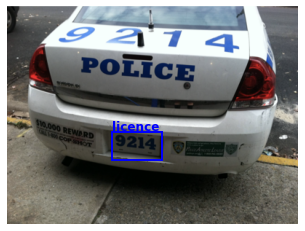

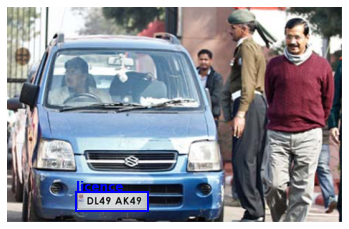

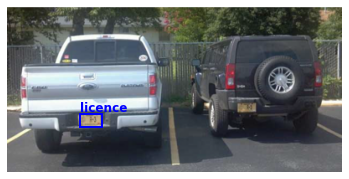

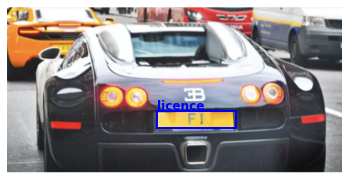

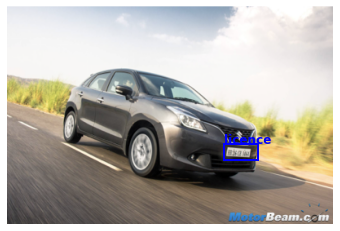

In [ ]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10

    if seed:
        rnd.seed(seed)

    random_photos = rnd.sample(photos, n)

    for image_path in random_photos:

        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)
            ax.axis(False)

            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])

                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')

photos_path = "dataset/images/*.png"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

In [ ]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("dataset/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])

    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])

    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height

    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)

    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'

    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'


    with open("dataset/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)


df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,Cars213.png,400,300,150,160,233,194,0.478750,0.590000,0.207500,0.113333
1,Cars207.png,400,478,254,229,372,264,0.782500,0.515690,0.295000,0.073222
2,Cars398.png,400,300,72,139,196,222,0.335000,0.601667,0.310000,0.276667
3,Cars367.png,450,299,224,161,382,222,0.673333,0.640468,0.351111,0.204013
4,Cars401.png,400,300,158,223,238,240,0.495000,0.771667,0.200000,0.056667
...,...,...,...,...,...,...,...,...,...,...,...
466,Cars418.png,400,225,99,70,303,155,0.502500,0.500000,0.510000,0.377778
467,Cars395.png,400,301,241,182,288,205,0.661250,0.642857,0.117500,0.076412
468,Cars381.png,400,225,65,131,147,155,0.265000,0.635556,0.205000,0.106667
469,Cars222.png,400,230,178,158,235,170,0.516250,0.713043,0.142500,0.052174


In [ ]:
input_folder = Path("dataset/")
output_folder = Path("preprocessed_dataset/")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 1299 files [00:01, 964.78 files/s] 

Moving files finished.


In [ ]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")


walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 3 directiories and 1 files in 'dataset' folder 
There are 0 directiories and 433 files in 'dataset/images' folder 
There are 0 directiories and 433 files in 'dataset/labels' folder 
There are 0 directiories and 433 files in 'dataset/annotations' folder 

There are 2 directiories and 1 files in 'preprocessed_dataset' folder 
There are 3 directiories and 2 files in 'preprocessed_dataset/train' folder 
There are 0 directiories and 346 files in 'preprocessed_dataset/train/images' folder 
There are 0 directiories and 346 files in 'preprocessed_dataset/train/labels' folder 
There are 0 directiories and 346 files in 'preprocessed_dataset/train/annotations' folder 
There are 3 directiories and 2 files in 'preprocessed_dataset/val' folder 
There are 0 directiories and 87 files in 'preprocessed_dataset/val/images' folder 
There are 0 directiories and 87 files in 'preprocessed_dataset/val/labels' folder 
There are 0 directiories and 87 files in 'preprocessed_dataset/val/annotations' fol

In [ ]:
yaml_file = 'yolov5/data/plates.yaml'

yaml_data = dict(
    path = "../preprocessed_dataset",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [ ]:
device = '0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Training the model - Done in terminal

In [ ]:
'python yolov5/train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "yolov5/data/plates.yaml" --weights yolov5n.pt --device {device} --cache end_time = timer()'

'python yolov5/train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "yolov5/data/plates.yaml" --weights yolov5n.pt --device {device} --cache end_time = timer()'

## Reading the number plates

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp/weights/best.pt', force_reload = True)

reader = easyocr.Reader(['en'])

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/dhruva_macintosh/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-26 Python-3.8.7 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Get the results from easyOCR for each frame and return them with bounding box coordinates'''

    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## BBOx coordniates
    plate_crop = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## BBox
    ocr_result = reader.readtext(np.asarray(plate_crop), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')#, paragraph="True", min_size=50)

    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float=0.3) -> list:
    '''Checks the detection's probability, discards those with low prob and rewrites output from ocr_reader to >>detections<< list'''

    if row[4] >= yolo_detection_prob: #discard predictions below the value
        if(len(ocr_result))>0:
            for item in ocr_result:
                    detections[i][0]=item[1]
                    detections[i][1]=[x1, y1]
                    detections[i][2]=item[2]

    return detections


def is_adjacent(coord1: list, coord2: list) -> bool:
    '''Checks if [x, y] from list coord1 is similar to coord2'''

    MAX_PIXELS_DIFF=50

    if (abs(coord1[0] - coord2[0]) <= MAX_PIXELS_DIFF) and (abs(coord1[1] - coord2[1]) <= MAX_PIXELS_DIFF):
        return True
    else:
        return False


def sort_detections(detections: list, plates_data: list) -> list:
    '''Looks at detections from last frame and rewrites indexes for similar coordinates'''

    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1]==[0, 0] and not plates_data[n][1]==[0,0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m!=n:
                        temp=detections[m]
                        detections[m]=detections[n]
                        detections[n]=temp

    return detections


def delete_old_labels(detections: list, count_empty_labels: list, plates_data: list, frames_to_reset: int=3) -> tuple:
    '''If earlier detected plate isn't spotted for the next >>FRAMES_TO_RESET<< frames, delete it from >>plates_data<<'''

    for m in range(0, len(detections)):
        if detections[m][0]=='None' and not count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]+=1
        elif count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]=0
            plates_data[m]=['None', [0,0], 0]
        else:
            count_empty_labels[m]=0

    return plates_data, count_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_lenght=None) -> list:
    '''Checks coordinates from >>detections<<, if there is similar record in >>plate_data<< tries to overwrite it (only if probability is higher)'''

    if (detections[i][2]>plates_data[i][2] or detections[i][2]==0):
        if plate_lenght:
            if len(detections[i][0])==plate_lenght:
                plates_data[i][0]=detections[i][0]
                plates_data[i][2]=detections[i][2]
        else:
            plates_data[i][0]=detections[i][0]
            plates_data[i][2]=detections[i][2]
    plates_data[i][1]=detections[i][1]

    return plates_data

Photo width,height: 252,129. Detected plates: 1
Detection: 1. YOLOv5 prob: 0.81, easyOCR results: [[[[7, 0], [157, 0], [157, 33], [7, 33]], 'CGOA4MF2250']]


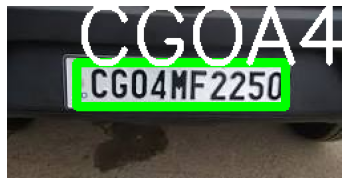

In [ ]:
%matplotlib inline

test_photo_path = "1.jpeg"

results = model(test_photo_path)
detections=np.squeeze(results.render())

labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
image = cv2.imread(test_photo_path)
width, height = image.shape[1], image.shape[0]

print(f'Photo width,height: {width},{height}. Detected plates: {len(labels)}')

for i in range(len(labels)):
    row = coordinates[i]
    if row[4] >= 0.6:
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext((plate_crop), paragraph="True", min_size=120, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        text=ocr_result[0][1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
        cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        plt.axis(False)
        plt.imshow((image)[...,::-1])

        print(f'Detection: {i+1}. YOLOv5 prob: {row[4]:.2f}, easyOCR results: {ocr_result}')

In [ ]:
video_path = "Sample_video.mp4"
cap = cv2.VideoCapture(video_path)

plates_data = [['None', [0,0], 0] for n in range(5)]
count_empty_labels=[0]*5

assert cap.isOpened()

while(cap.isOpened()):
    ret, frame = cap.read()
    assert not isinstance(frame,type(None)), 'frame not found'
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    results = model(frame)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)

    labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
    width, height = frame.shape[1], frame.shape[0]

    detections=[['None', [0,0], 0] for n in range(5)]
    i=0


    ## Read all detected plates per each frame and save them to >>detections<<
    while i < len(labels):
        row = coordinates[i]
        ## 3. Crop detections and pass them to the easyOCR
        ocr_result, x1, y1=get_plates_xy(frame, labels, row, width, height, reader)

        ## 4. Get reading for the each frame
        detections=detect_text(i, row, x1, y1, ocr_result, detections, 0.5)
        i+=1
    i=0

    ## 5. Do some tracking and data managing for better results
    ## If we get multiple detections in one frame easyOCR mixes them every few frames, so here we make sure that they are saved according to the \
    ## detections' coordinates. Then we delete data about plates that dissapeared for more than >>frames_to_reset<< frames. And finally we overwrite \
    ## the predictions (regarding to the probability of easyOCR detections - if new predcition has less p% than the previous one, we skip it.)

    ## Sort detections
    detections=sort_detections(detections, plates_data)

    ## Delete data about plates that dissapeared from frame
    plates_data, count_empty_labels=delete_old_labels(detections, count_empty_labels, plates_data, 3)

    ## Overwrite data and print text predictions over the boxes
    while i < len(labels):
        plates_data=overwrite_plates_data(detections, plates_data, 7)
        cv2.putText(frame, f"{plates_data[i][0]}", (plates_data[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        i+=1

    cv2.imshow('YOLO & OCR', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()